In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.spatial.distance import pdist, squareform

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
from dask.diagnostics import ProgressBar
import duckdb
import sys
sys.path.append("../../scripts")
from initial_map import BarcodeMapper
from map_refiner import MapRefiner
import preprocess
import finder

import matplotlib.pyplot as plt

# Test flexible orders on CC NKX2-2 Step 1

In [155]:
mapper = BarcodeMapper(seq_file = ['../../data/Staller_Tl4s1_MVS_0035_I1TTGTCACCAA_CGCACGAACA_S326.fastq.gz.assembled.fastq'],
                        design_file_path = "../../data/DNA_Tiles_nkx2_2.txt",
                        bc_names = ["ADBC2", "HawkBCs", "RTBC", "AD"],
                        preceders = ["CTCGAGATAACTTCGTATAATGTATGCTAT", "GAGCTCGCTAGC", "GGCCGGCCATAGGGCCCC", "CACCATG"],
                        posts = ["GGCCGGCCATAGGGCCCC", "CTCGAGATAA", "GCGGTCCA", "GGATCCG"],
                        lengths = [6, 9, 16, 162],
                      reverse_complement=False)
mapped_df = mapper.create_map()
preprocess.save_parquet(mapped_df, '../output/CC_nkx2_2.parquet')
mapped_df.head()

('reads_shortened.txt',)
[########################################] | 100% Completed | 716.50 ms


,ADBC2,ADBC2_qual,HawkBCs,HawkBCs_qual,RTBC,RTBC_qual,AD,AD_qual,Designed
0,NaN,False,NaN,False,NaN,False,NaN,False,0.0
1,NaN,False,ACCAAGATC,True,NaN,False,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,0.0
2,NaN,False,NaN,False,NaN,False,NaN,False,0.0
3,NaN,False,NaN,False,NaN,False,NaN,False,0.0
4,NaN,False,NaN,False,NaN,False,NaN,False,0.0


Using map order: ['initial', 'quality_designed', 'grouped', 'unique_target', 'thresholded']


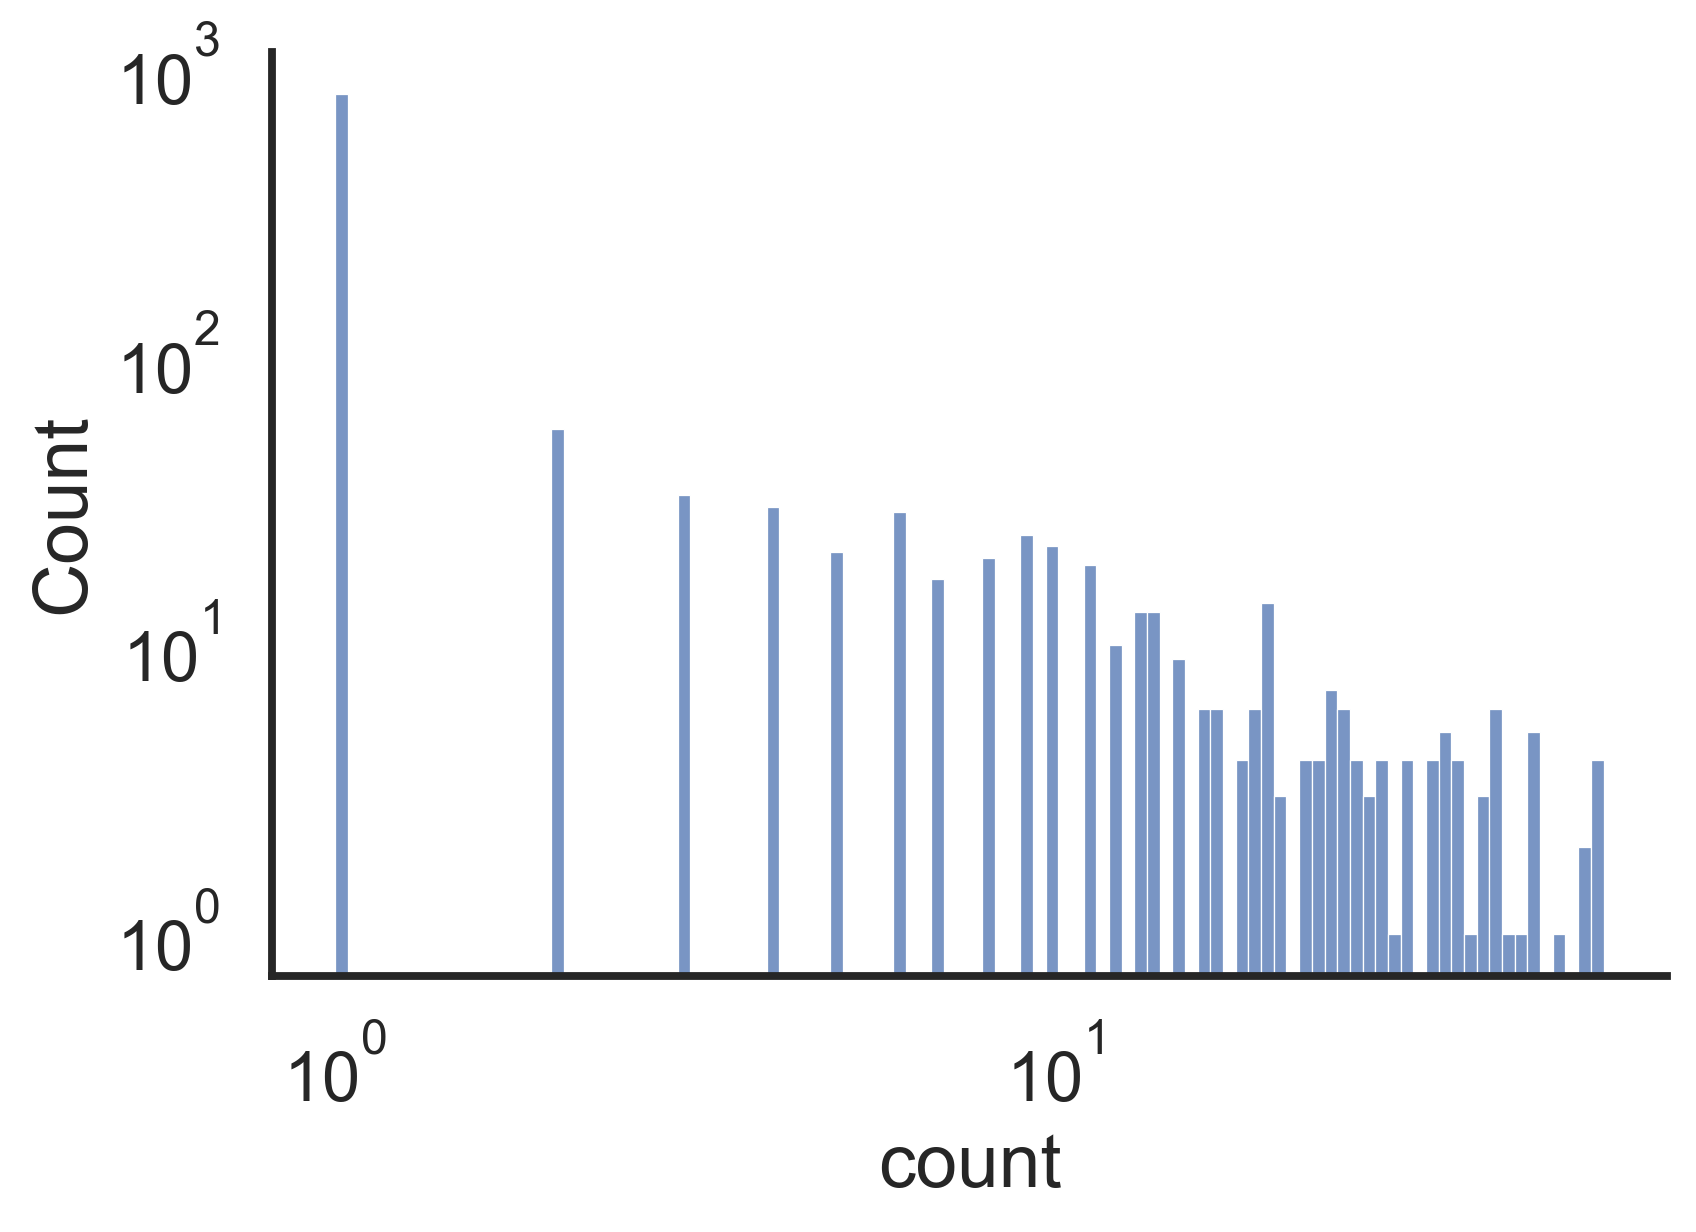

Using reads threshold of 10.


,map,description,num_rows,% of previous step,% of total reads
0,initial,Initial combinations,77535,100.00,100.00
1,quality_designed,After removing low quality and undesigned,51229,66.07,66.07
2,grouped,Grouped counts,7757,15.14,10.00
3,unique_target,Filtered for unique targets,1235,15.92,1.59
4,thresholded,Filtered by # reads > 10,177,14.33,0.23


In [200]:
threshold_last_refiner = MapRefiner(db_path = "../../duckdb/CC_nkx2_2_threshold_last",
                      cols = ["ADBC2", "HawkBCs", "RTBC", "AD"],
                     column_pairs = [("AD", ("ADBC2", "HawkBCs")), (("ADBC2", "HawkBCs"), "RTBC")],
                     map_order = ["initial", "quality_designed", "grouped", "unique_target", "thresholded"])
threshold_last_refiner.refine_map_from_parquet("../../output/CC_nkx2_2.parquet/*")
threshold_last_refiner.save_loss_table()

Using map order: ['initial', 'quality_designed', 'grouped', 'thresholded', 'unique_target']


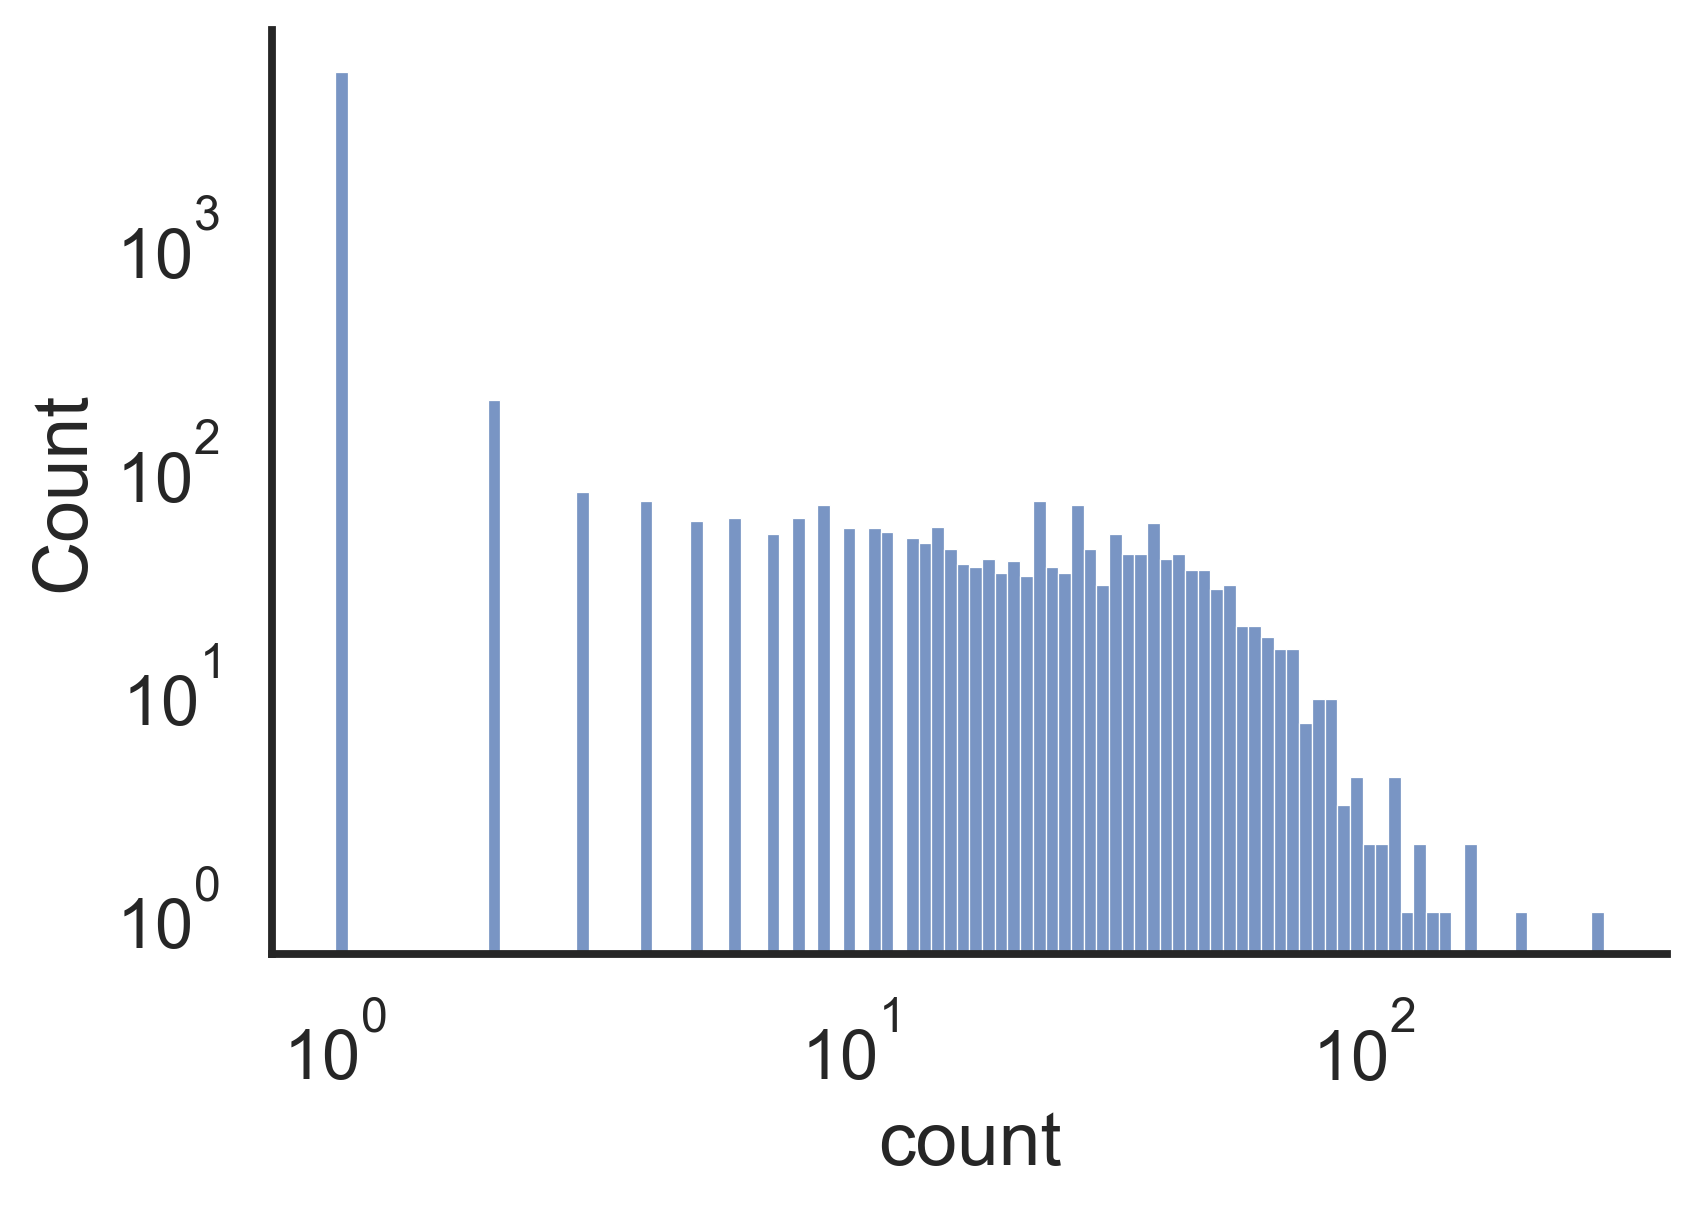

Using reads threshold of 10.


,map,description,num_rows,% of previous step,% of total reads
0,initial,Initial combinations,77535,100.00,100.00
1,quality_designed,After removing low quality and undesigned,51229,66.07,66.07
2,grouped,Grouped counts,7757,15.14,10.00
3,thresholded,Filtered by # reads > 10,1295,16.69,1.67
4,unique_target,Filtered for unique targets,1205,93.05,1.55


In [201]:
threshold_first_refiner = MapRefiner(db_path = "../../duckdb/CC_nkx2_2_threshold_first",
                      cols = ["ADBC2", "HawkBCs", "RTBC", "AD"],
                     column_pairs = [("AD", ("ADBC2", "HawkBCs")), (("ADBC2", "HawkBCs"), "RTBC")],
                     map_order = ["initial", "quality_designed", "grouped", "thresholded", "unique_target"])
threshold_first_refiner.refine_map_from_parquet("../../output/CC_nkx2_2.parquet/*")
threshold_first_refiner.save_loss_table()

Using map order: ['initial', 'grouped', 'thresholded', 'unique_target', 'quality_designed']


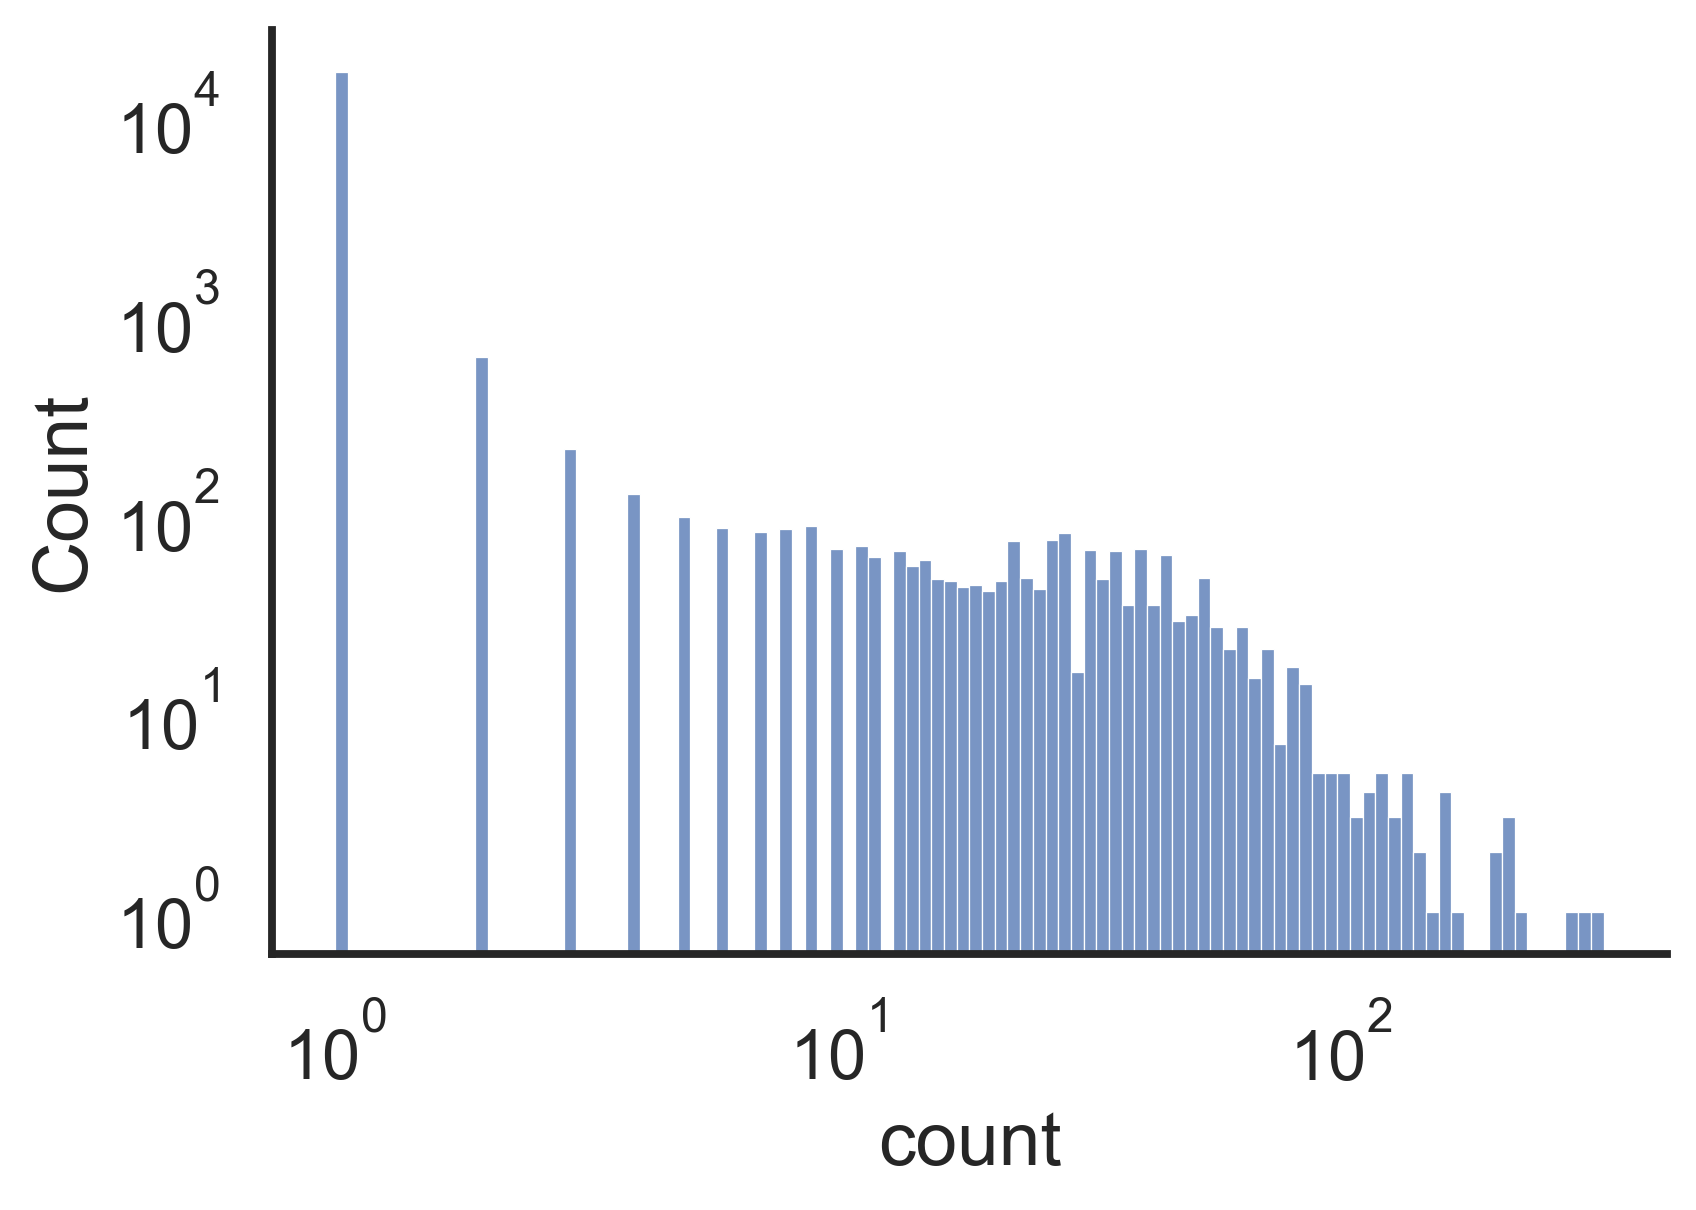

Using reads threshold of 10.


,map,description,num_rows,% of previous step,% of total reads
0,initial,Initial combinations,77535,100.00,100.00
1,grouped,Grouped counts,19899,25.66,25.66
2,thresholded,Filtered by # reads > 10,1595,8.02,2.06
3,unique_target,Filtered for unique targets,1349,84.58,1.74
4,quality_designed,After removing low quality and undesigned,1201,89.03,1.55


In [202]:
sk_order_refiner = MapRefiner(db_path = "../../duckdb/CC_nkx2_2_sk_order",
                      cols = ["ADBC2", "HawkBCs", "RTBC", "AD"],
                     column_pairs = [("AD", ("ADBC2", "HawkBCs")), (("ADBC2", "HawkBCs"), "RTBC")],
                     map_order = ["initial", "grouped", "thresholded", "unique_target", "quality_designed"])
sk_order_refiner.refine_map_from_parquet("../../output/CC_nkx2_2.parquet/*")
sk_order_refiner.save_loss_table()

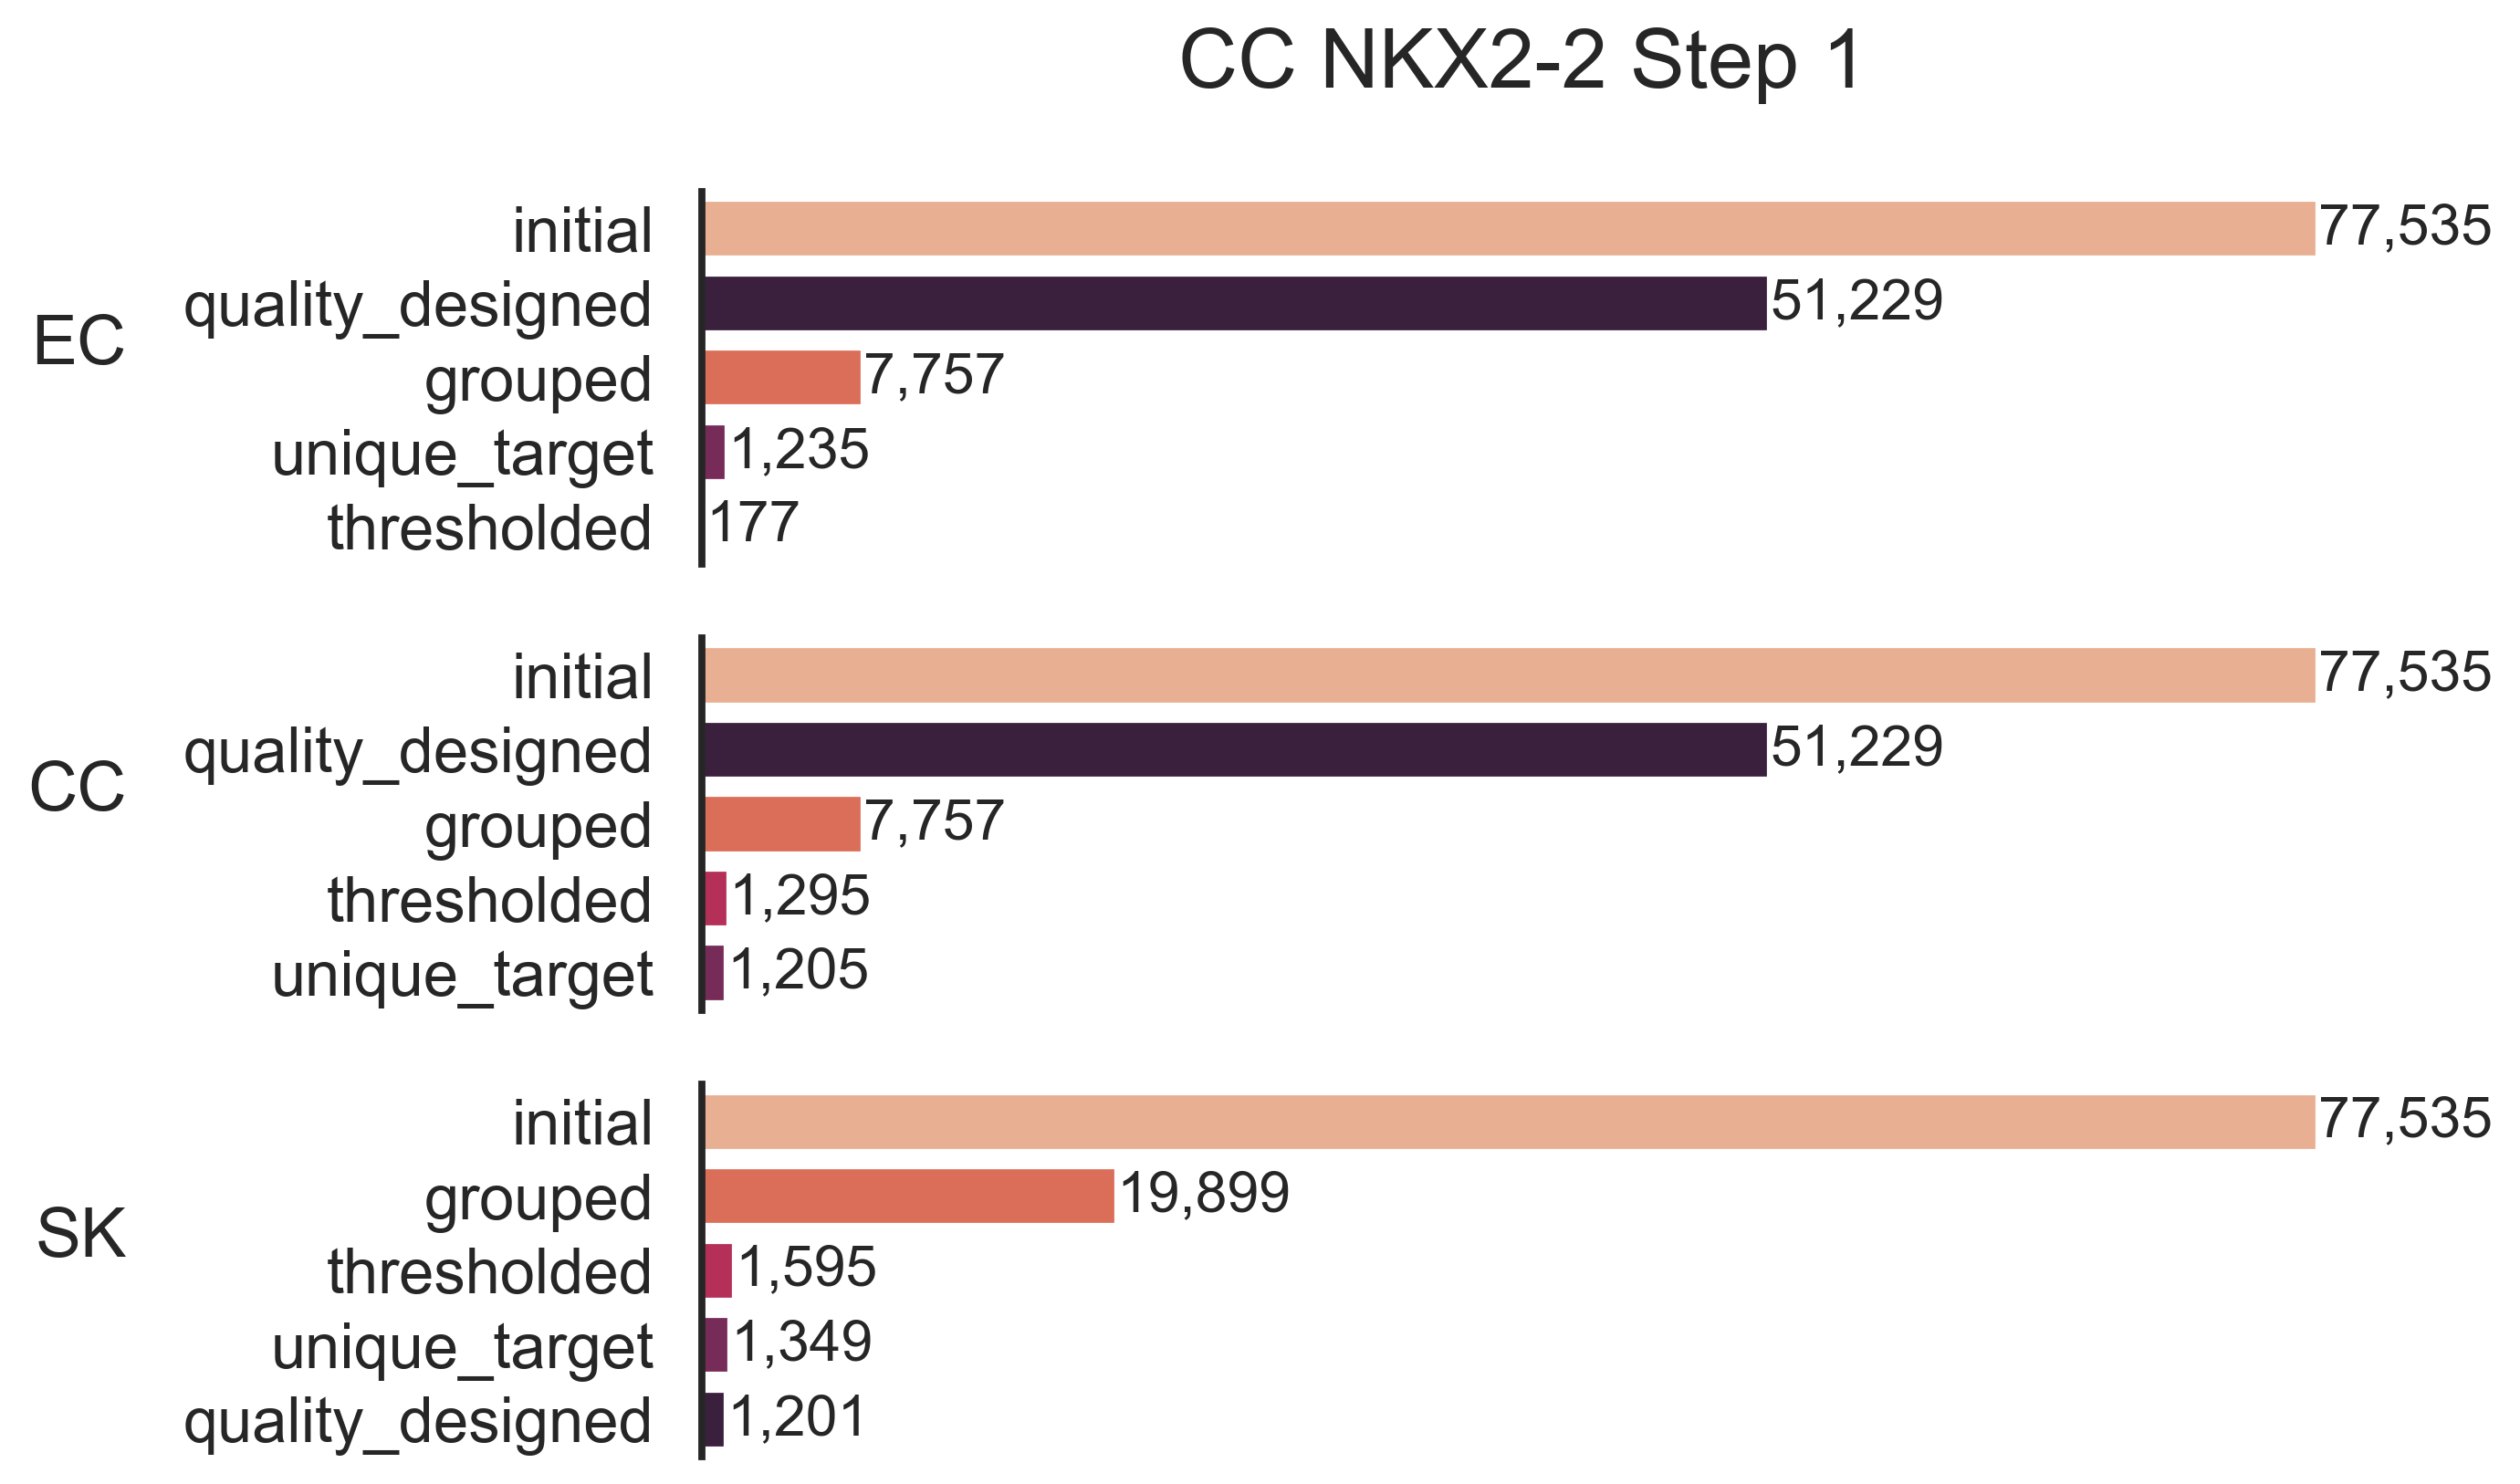

In [203]:
fig, axs = plt.subplots(3,1, figsize = (8,6), dpi = 300, sharex = True)

sns.set_context('talk')

threshold_last_refiner.plot_loss(ax = axs[0])
axs[0].set_ylabel("EC", rotation = 0, ha = 'right', labelpad = 15)

threshold_first_refiner.plot_loss(ax = axs[1])
axs[1].set_ylabel("CC", rotation = 0, ha = 'right', labelpad = 15)

sk_order_refiner.plot_loss(ax = axs[2])
axs[2].set_ylabel("SK", rotation = 0, ha = 'right', labelpad = 15)

fig.suptitle("CC NKX2-2 Step 1")

for ax in axs:
    ax.set_xlabel("")

# Test flexible orders on EC Step 1

In [7]:
EC_threshold_last_refiner = MapRefiner(db_path = "../../duckdb/EC_threshold_last_refiner",
                      cols = ["AD", "AD_BC", "RPTR_BC"],
                     reads_threshold = 50,
                     column_pairs = [("AD", "AD_BC"), ("AD_BC", "RPTR_BC")],
                     map_order = ["initial", "quality_designed", "grouped", "unique_target", "thresholded"])
EC_threshold_last_refiner.refine_map_from_parquet('/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/SK_CURRENT_A10_1_tbcRAW_v2.parquet/*')
EC_threshold_last_refiner.save_loss_table()

Using map order: ['initial', 'quality_designed', 'grouped', 'unique_target', 'thresholded']


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,map,description,num_rows,% of previous step,% of total reads
0,initial,Initial combinations,138671404,100.00,100.00
1,quality_designed,After removing low quality and undesigned,17756542,12.80,12.80
2,grouped,Grouped counts,623956,3.51,0.45
3,unique_target,Filtered for unique targets,239182,38.33,0.17
4,thresholded,Filtered by reads_threshold > 50,33672,14.08,0.02


In [8]:
EC_threshold_first_refiner = MapRefiner(db_path = "../../duckdb/EC_threshold_first_refiner",
                      cols = ["AD", "AD_BC", "RPTR_BC"],
                     reads_threshold = 50,
                     column_pairs = [("AD", "AD_BC"), ("AD_BC", "RPTR_BC")],
                     map_order = ["initial", "quality_designed", "grouped",  "thresholded", "unique_target"])
EC_threshold_first_refiner.refine_map_from_parquet('/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/SK_CURRENT_A10_1_tbcRAW_v2.parquet/*')
EC_threshold_first_refiner.save_loss_table()

Using map order: ['initial', 'quality_designed', 'grouped', 'thresholded', 'unique_target']


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,map,description,num_rows,% of previous step,% of total reads
0,initial,Initial combinations,138671404,100.00,100.00
1,quality_designed,After removing low quality and undesigned,17756542,12.80,12.80
2,grouped,Grouped counts,623956,3.51,0.45
3,thresholded,Filtered by reads_threshold > 50,127622,20.45,0.09
4,unique_target,Filtered for unique targets,121818,95.45,0.09


In [9]:
EC_sk_order_refiner = MapRefiner(db_path = "../../duckdb/EC_sk_order_refiner",
                      cols = ["AD", "AD_BC", "RPTR_BC"],
                     reads_threshold = 50,
                     column_pairs = [("AD", "AD_BC"), ("AD_BC", "RPTR_BC")],
                     map_order = ["initial", "grouped", "thresholded", "unique_target", "quality_designed"])
EC_sk_order_refiner.refine_map_from_parquet('/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/SK_CURRENT_A10_1_tbcRAW_v2.parquet/*')
EC_sk_order_refiner.save_loss_table()

Using map order: ['initial', 'grouped', 'thresholded', 'unique_target', 'quality_designed']


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,map,description,num_rows,% of previous step,% of total reads
0,initial,Initial combinations,138671404,100.00,100.00
1,grouped,Grouped counts,15534161,11.20,11.20
2,thresholded,Filtered by reads_threshold > 50,758783,4.88,0.55
3,unique_target,Filtered for unique targets,276806,36.48,0.20
4,quality_designed,After removing low quality and undesigned,119347,43.12,0.09


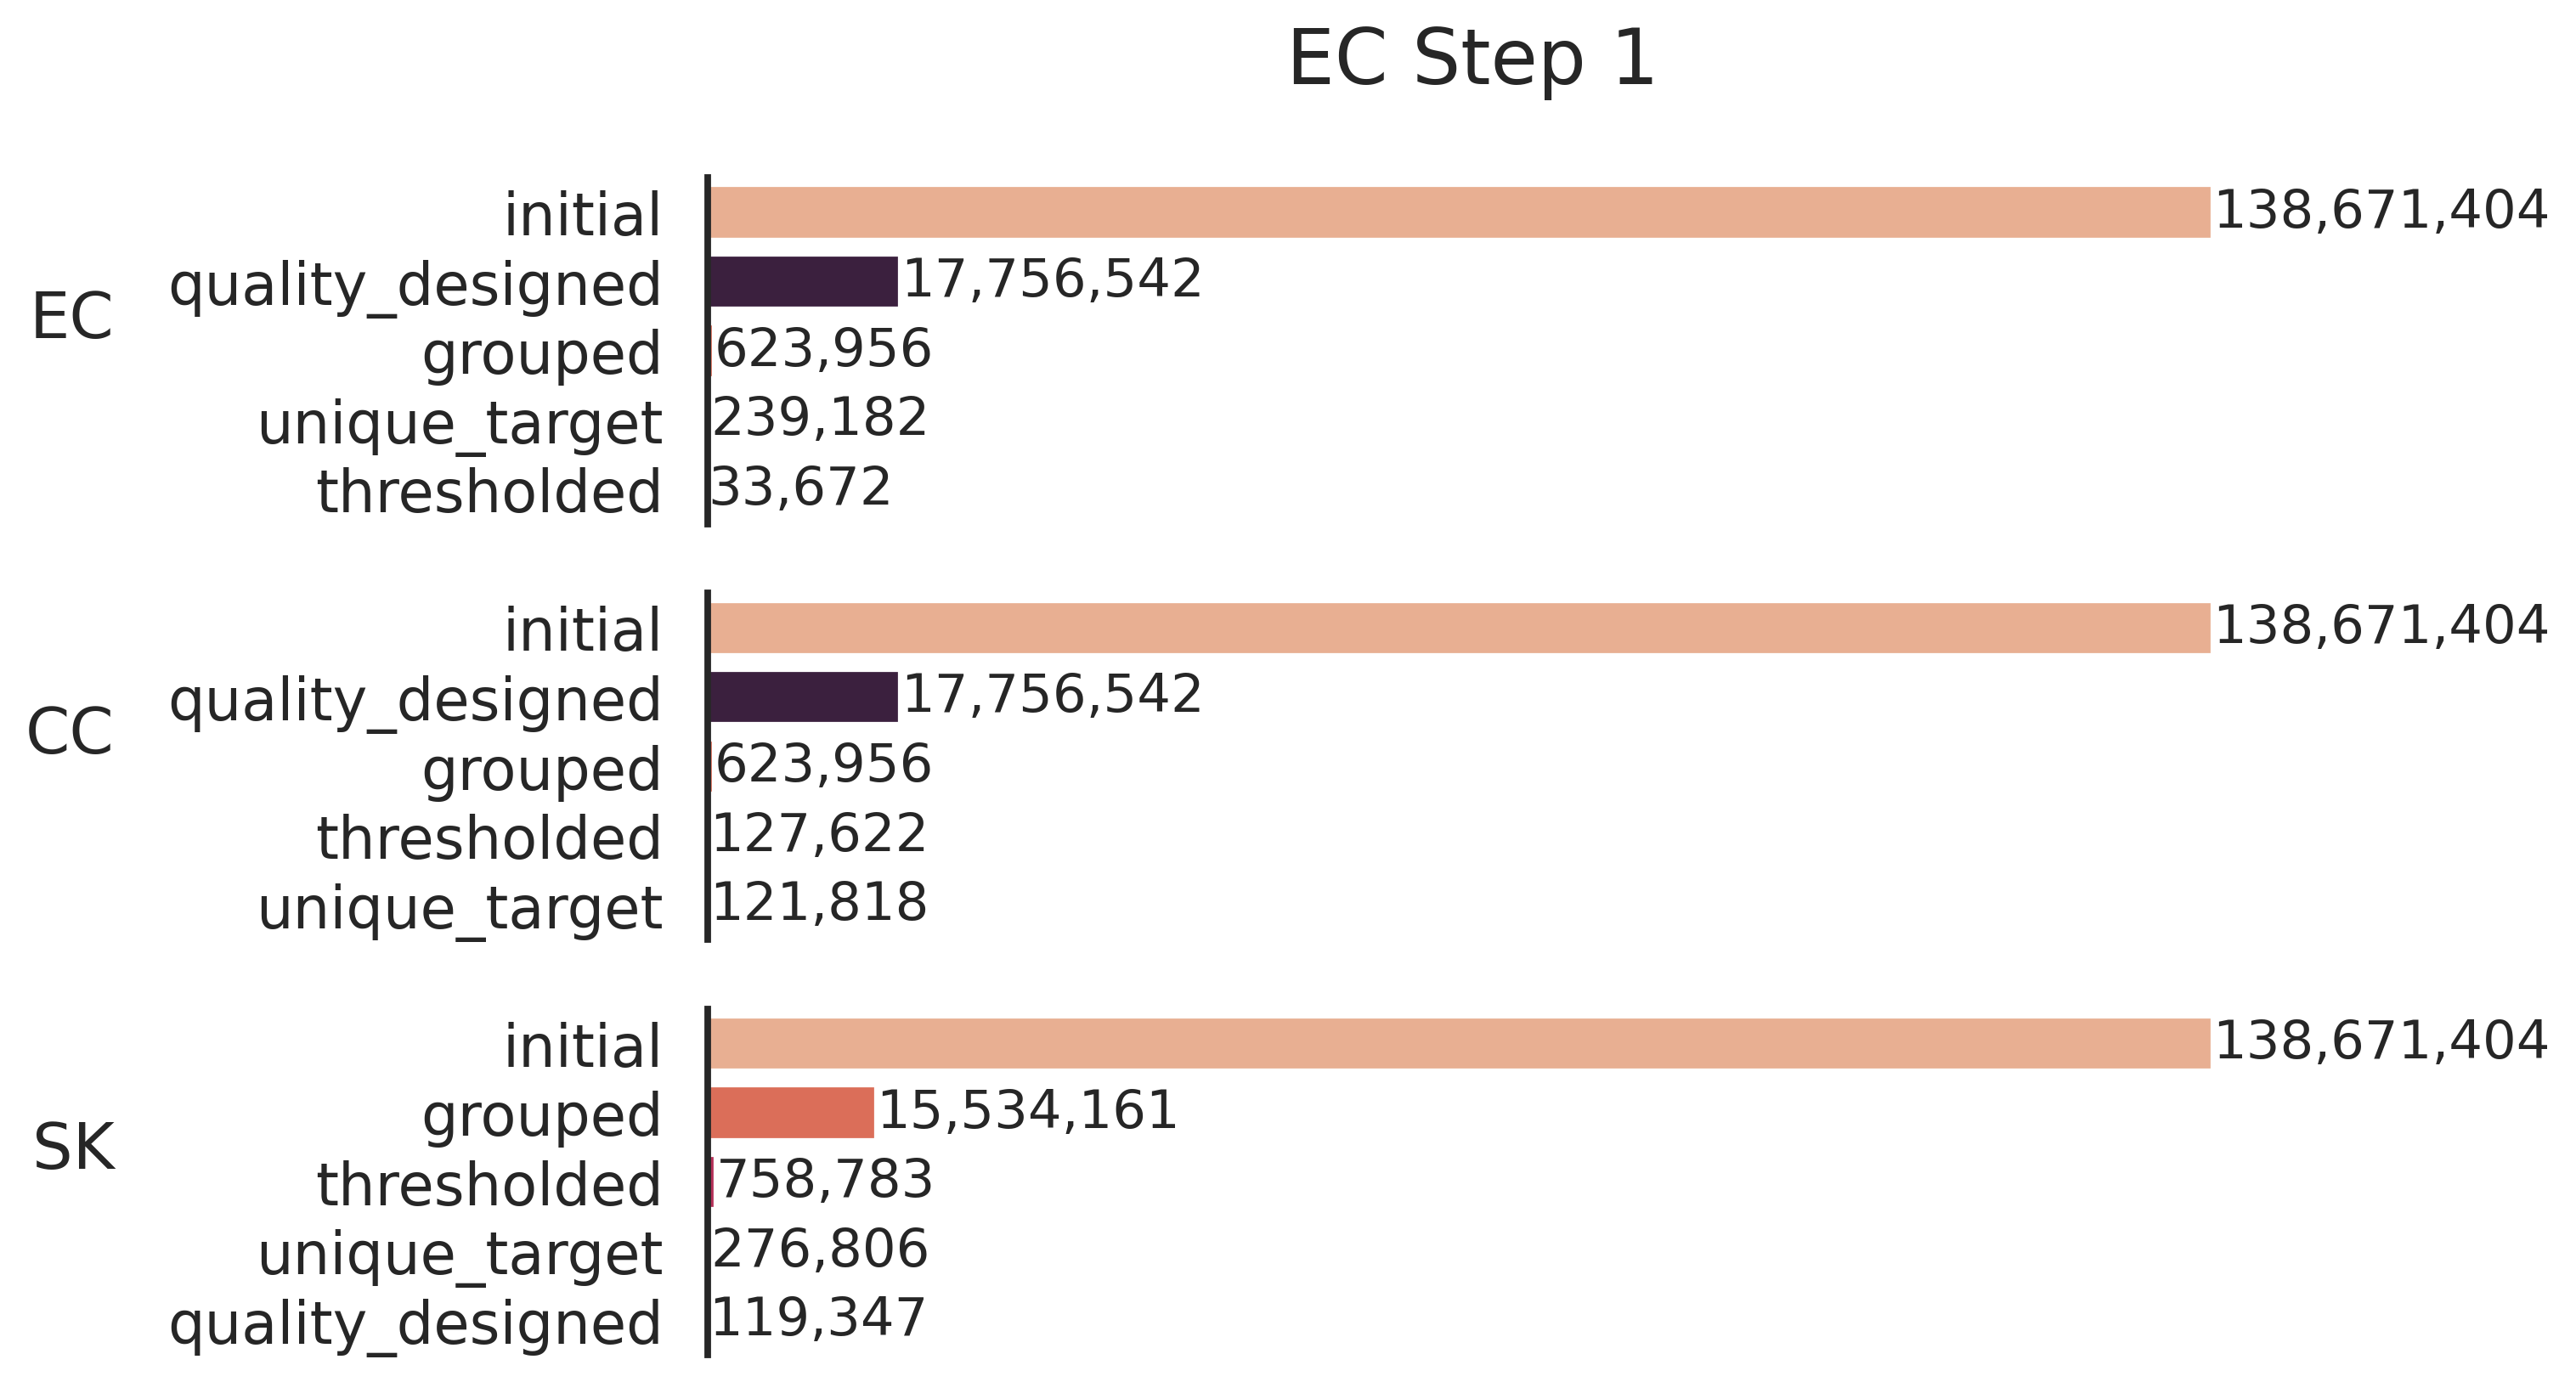

In [12]:
fig, axs = plt.subplots(3,1, figsize = (8,6), dpi = 300, sharex = True)

sns.set_context('talk')

EC_threshold_last_refiner.plot_loss(ax = axs[0])
axs[0].set_ylabel("EC", rotation = 0, ha = 'right', labelpad = 15)

EC_threshold_first_refiner.plot_loss(ax = axs[1])
axs[1].set_ylabel("CC", rotation = 0, ha = 'right', labelpad = 15)

EC_sk_order_refiner.plot_loss(ax = axs[2])
axs[2].set_ylabel("SK", rotation = 0, ha = 'right', labelpad = 15)

fig.suptitle("EC Step 1")


for ax in axs:
    ax.set_xlabel("")